# Lab 10: Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network. 


## 1. Example

This assignement should be run on Google Colab where you can use free GPU to accelerate the computation. Please refer to our slides to set up GPU. 

[![Open In Colab][colab badge]][colab]

[colab badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab]: https://colab.research.google.com/github/lduran2/CIS3715_DataScience_2022/blob/lab10/Lab10/Lab10.ipynb

### 1. Install Pytorch

In [ ]:
!pip3 install torch torchvision   # install pytorch

### 2. Check GPU

In [ ]:
!/opt/bin/nvidia-smi  #show GPU 

Sun Apr 10 03:04:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3. Mount to google drive (optional)

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 4. Code

In [ ]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
args={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['log_interval']=10

In [ ]:
def seed_rnd(a_seed):
    '''
    Seeds all relevant RND libaries.
    '''
    # import and seed numpy if unused
    import numpy
    numpy.random.seed(a_seed)
    # seed Pytorch
    torch.manual_seed(a_seed)
    # seed the GPU(s)
    torch.cuda.manual_seed_all(a_seed)
# end seed_rnd(a_seed)

In [ ]:
# use a constant random seed to make experiment repeatable
seed_rnd(42)

In [ ]:
# build an mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

## 2. Tasks

I have changed the `train` and `test` functions
and added some of my own to make it possible to aggregate loss and accuracy.

In [ ]:
def printTrainReport(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss):
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss))
# end def printTrainReport(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)

In [ ]:
def createAppendLossTo(queue):
    def appendLossToQueue(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss):
        queue.append(r_loss)
    # end def appendLossToQueue(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)
    return appendLossToQueue
# end def createAppendLossTo(queue)(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)

In [ ]:
def train(epoch, callbacks=[printTrainReport]):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()

        #Apply callbacks to the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            for callback in callbacks:
                callback(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item())

In [ ]:
def printTestReport(epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy):
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy))
# end def printTestReport(epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)

In [ ]:
def createAppendAccuracyTo(queue):
    def appendAccuracyToQueue(
          epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy):
        queue.append(pc_accuracy)
    # end def appendAccuracyToQueue(
    #     epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)
    return appendAccuracyToQueue
# end def createAppendAccuracyTo(queue)(
#     epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)

In [ ]:
def test(epoch=-1, callbacks=[printTestReport]):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    for callback in callbacks:
        callback(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset))

### 1. Please use other activation functions, e.g., sigmoid, tanh, and then plot the training loss and testing accuracy. 

When plotting the training loss, the x-axis is iteration and the y-axis is training loss. When plotting the testing accuracy,  the x-axis is epoch and the y-axis is the training loss.

In [ ]:
#Create callback for appending losses.
losses = []
appendLoss = createAppendLossTo(losses)

#Create callback for appending accuracies.
accuracies = []
appendAccuracy = createAppendAccuracyTo(accuracies)

#loop through epoches.
for epoch in range(1, args['epochs'] + 1):
    train(epoch, callbacks=(printTrainReport, appendLoss))
    test(epoch, callbacks=(printTestReport, appendAccuracy))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307205
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.265357
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.224665
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.230098
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.189282
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.163362
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.121968
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.090820
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.041341
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.963370
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.892034
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.851569
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.843171
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.718554
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.568165
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.560181
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.460177
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.393085
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.230321
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.244536
Train Epoch: 1 [200

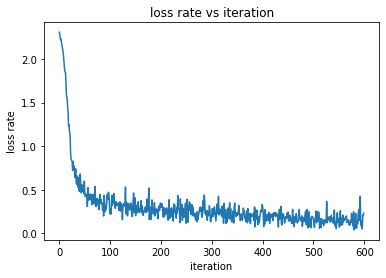

In [ ]:
# plot the loss
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_title('loss rate vs iteration')
ax.set_xlabel('iteration')
ax.set_ylabel('loss rate')
fig.show()

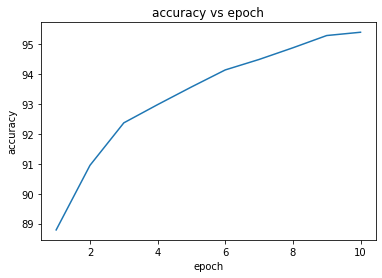

In [ ]:
# plot the accuracy
fig, ax = plt.subplots(1, 1)
epoch_nos = range(1, (len(accuracies) + 1))
ax.plot(epoch_nos, accuracies)
ax.set_title('accuracy vs epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()

### 2. Please use different layers in the model, e.g., 1 layer, 5 layers, 10 layers,  and then plot the training loss and testing accuracy.

In [ ]:
# your code